In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

## Single step process flow

This is a multi step model for patient flow through a system. 

Each step feeds into the next:
1. Arrive - Check-in
2. Arrive - Waiting room wait
3. Arrive - Move to exam room
4. Exam - Vitals check
5. Exam - Refinement of complaint
6. Exam - Starting visit note
7. Exam - Provider exam
8. Conclusion - Check-out

Each step within it has the following processes:
1. Update service time passing _(relevant for periods after first period)_
2. Move patients out of service to next step and free up servers _(relevant for periods after first period)_
3. Take new arrivals into system
4. Check number of free servers
5. Decide how many patients to move into service from wait list and from new arrivals, based on number of free servers
6. Assign patients to free servers, from wait list and/or new arrivals
7. Update wait time passing
8. Add new arrivals not assigned to free servers to waiting queue

Each step has the following data describing the expected process service time:
- Mean service time
- Worst case additional service time
- Percent of time worst case occurs

## Functions

Functions for each process within a step

In [3]:
def generate_service_time_type_condition(data, n_new_service_times = 1, skew = 0.05, n_samples = 1000) :
    """Get randomized service time based on type of condition
    To be used only if step in model is Exam by provider"""
    # Choose random service time, with probabilities given by frequency
    condition_type = np.random.choice(data['Type'], p = data['Frequency']) 
    # Average service time for condition
    avg = data.loc[data['Type'] == condition_type, 'Time_Mean'].item() 
    # Worst case upper limit for condition
    worstcase = data.loc[data['Type'] == condition_type, 'Time_WorstCase'].item() 
    # % of time worst case for condition
    perc_worst_case = data.loc[data['Type'] == condition_type, 'Perc_WorstCase'].item() 
    # St Dev based on % of time worst case occurs
    std = worstcase / stats.skewnorm.ppf(1 - perc_worst_case, avg) 
    # Create distribution of 1000 samples based on condition type parameters
    dist = stats.skewnorm.rvs(skew, loc = avg, scale = std, size = n_samples)
    # Remove negative / too low results
    dist[dist < avg / 2] = avg / 2 
    # Return number of new service times needed (will always be 1 unless exceptional circumstances)
    serve_times = np.random.choice(dist, n_new_service_times) 
    # Round service times to nearest minute
    for i, s in enumerate(serve_times) :
        serve_times[i] = round(s)
    return condition_type, serve_times[0]

In [4]:
def generate_service_time_process(data, process, n_new_service_times = 1, skew = 0.05, n_samples = 1000) :
    """Get randomized service time based on process
    To be used only all steps in model except Exam by provider"""
    # Average service time for process
    avg = data.loc[data['Process'] == process, 'Time_Mean'].item() 
    # Worst case upper limit for process
    worstcase = data.loc[data['Process'] == process, 'Time_WorstCase'].item() 
    # % of time worst case for process
    perc_worst_case = data.loc[data['Process'] == process, 'Perc_WorstCase'].item() 
    # St Dev based on % of time worst case occurs
    std = worstcase / stats.skewnorm.ppf(1 - perc_worst_case, avg) 
    # Create distribution of 1000 samples based on condition type parameters
    dist = stats.skewnorm.rvs(skew, loc = avg, scale = std, size = n_samples)
    # Remove negative / too low results
    dist[dist < avg / 2] = avg / 2 
    # Return number of new service times needed (will always be 1 unless exceptional circumstances)
    serve_times = np.random.choice(dist, n_new_service_times) 
    # Round service times to nearest minute
    for i, s in enumerate(serve_times) :
        serve_times[i] = round(s)
    return serve_times[0]

In [5]:
def mark_service_time(dictionary_service, count_of_completed_service, service_time_tracker_dict,\
                      list_service_times_completed) :
    """Reduce the service time left for each patient to complete step by 1
    If service time  reduced to zero, remove patient from  dictionary, move to service completed, free up server
    Return modified service time dictionary
    In parallel, track completed service times to generate avg service time estimate post-simulation"""
    # Reduce service time left to complete step
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            continue
        else :
            dictionary_service[k] -= 1
            # Count patient as completed step and free up server if service time is 0 
            if dictionary_service[k] == 0 :
                count_of_completed_service += 1
                dictionary_service[k] = np.nan
    # For patients who are marked as completed, track the actual service time
    # completion for noting after simulation
    keys_for_removal = list()
    for k in service_time_tracker_dict.keys() :
        service_time_tracker_dict[k][0] += 1
        if service_time_tracker_dict[k][0] == service_time_tracker_dict[k][1] :
            list_service_times_completed.append(service_time_tracker_dict[k][1])
            keys_for_removal.append(k)
    for k in keys_for_removal :
        del service_time_tracker_dict[k]
    return dictionary_service, count_of_completed_service, list_service_times_completed

In [6]:
def check_servers_free(dictionary_service) :
    """Verify if servers are free (denoted by np.nan as value for server key)
    And, if free servers exist, how many"""
    count_servers_free = 0
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            count_servers_free += 1
    return count_servers_free

In [7]:
def how_many_to_move_from_where(dictionary_waiting, count_servers_free, count_n_arrivals) :
    """Determine how many people to move from wait list to service / from new arrivals to service"""
    count_from_wait_list = min(len(dictionary_waiting.keys()), count_servers_free)
    count_servers_free = count_servers_free - count_from_wait_list
    count_from_new_arrivals = min(count_n_arrivals, count_servers_free)
    return count_from_wait_list, count_from_new_arrivals

In [8]:
def move_from_wait_list_to_service(dictionary_waiting, dictionary_service, count_from_wait_list,\
                                   list_waiting_time, service_time_tracker_dict, process) :
    """Move patients from wait list to free servers
    To be preceded by: if count_from_wait_list > 0"""
    patients_on_wait_list = np.sort(list(dictionary_waiting.keys()))
    patients_move_to_serve = patients_on_wait_list[:count_from_wait_list]
    for m in patients_move_to_serve :
        list_waiting_time.append(dictionary_waiting[m])
        del dictionary_waiting[m]
        for k, v in dictionary_service.items() :
            if np.isnan(v) :
                if process == 'Exam' :
                    condition, serve_time = generate_service_time_type_condition(base_case_types)
                else :
                    serve_time = generate_service_time_process(process_flow, process)
                    if process == 'Refine_complaint' :
                        serve_time += pass_through_steps['Time_Mean'].sum()
                dictionary_service[k] = serve_time
                unique_key = 'Service_' + str(serve_time) + '_' + str(p)
                service_time_tracker_dict[unique_key] = [0, serve_time]
    return dictionary_waiting, dictionary_service, list_waiting_time, service_time_tracker_dict

In [9]:
def move_from_arrival_to_service(dictionary_service, count_n_arrivals, count_from_new_arrivals,\
                                 service_time_tracker_dict, process) :
    """Move patients from arrivals to free servers
    To be preceded by: if count_from_new_arrivals > 0 """
    count_arrivals_placed = 0
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            if process == 'Exam' :
                condition, serve_time = generate_service_time_type_condition(base_case_types)
            else :
                serve_time = generate_service_time_process(process_flow, process)
                if process == 'Refine_complaint' :
                    serve_time += pass_through_steps['Time_Mean'].sum()
            dictionary_service[k] = serve_time
            unique_key = 'Service_' + str(serve_time) + '_' + str(p)
            service_time_tracker_dict[unique_key] = [0, serve_time]
            count_arrivals_placed += 1
            if count_arrivals_placed >= count_from_new_arrivals :
                break
    return dictionary_service, count_arrivals_placed, service_time_tracker_dict

In [10]:
def add_to_wait_list(dictionary_waiting, count_n_arrivals, count_arrivals_placed) :
    """Move patients from arrivals to wait list
    To be preceded by: if arrivals_placed < n_arrivals"""
    count_diff = count_n_arrivals - count_arrivals_placed
    wait_keys = np.sort(list(dictionary_waiting.keys()))
    for i in range(count_diff) :
        if len(wait_keys) < 1 :
            new_waitname = 'Waiting' + str(i)
            dictionary_waiting[new_waitname] = 1
        else :
            count_lastwaiter = int(wait_keys[-1][7:])
            new_waitname = 'Waiting' + str(count_lastwaiter + i + 1)
            dictionary_waiting[new_waitname] = 1
    return dictionary_waiting

In [11]:
def generate_step_objects(n_servers, n_periods) :
    """Function to generate step tracking objects"""
    # Treat servers as dictionary to keep track of who is busy
    # NaN means empty server
    # If busy, dict will take form of {'Server#': n_minutes_left_service}
    dictionary_servers = {}
    for i in range(n_servers) :
        servname = 'Server' + str(i)
        dictionary_servers[servname] = np.nan
    # Treat waiting as dictionary
    # If someone waits, will be added to dictionary with form of {'Waiting#': n_minutes_waiting}
    dictionary_waiting = {}
    # Temporary tracker dictionary for service times
    dictionary_track_serve_time = {}
    # Holding lists for completed service times and completed waiting times (for measurement post-simulation)
    list_waiting_times = list()
    list_service_completed_times = list()
    # Set counter for completed service to 0
    count_service_completed = 0
    # Array for holding onto step-by-step process
    # Shape: number_of_periods x 4 -> [n_arrivals, n_being_served, n_waiting, n_completed]
    tracker = np.zeros(shape = (n_periods, 4))
    return dictionary_servers, dictionary_waiting, dictionary_track_serve_time, list_waiting_times,\
list_service_completed_times, count_service_completed, tracker

## Parameters for model

In [12]:
# Estimates for how often the worst case scenario in patient service times occurs
low = 0.05
medium = 0.1
high = 0.2

In [13]:
# Providers available
providers = {'Doctor': 9, 'Nurse': 5, 'FlowStaff': 20, 'CSR': 10}
providers

{'Doctor': 9, 'Nurse': 5, 'FlowStaff': 20, 'CSR': 10}

In [14]:
# Time estimates for each step in the patient journey
# Time estimates for Exam by provider (currently NaN's) to come from times by condition type (below)
# Consolidated by Step and Server to simplify 
# -key assumption1 : only preserving variability on steps that have variability built-in, rather than waiting time
# -key assumption2 : steps that have no WorstCase are straight pass throughs and added to overall service time,
#                    so only steps to be considered for queueing variability are check_in, refine_complaint, 
#                    exam, and checkout 
# -key assumption3 : CSR are split between check_in and check_out
cols = ['Step', 'Process', 'Staff', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
checkin = ['Arrive', 'Check_in', 'CSR', 2, 3, low]
wait = ['Arrive', 'Waiting_room', 'FlowStaff', 3, 0, low]
to_room = ['Arrive', 'To_exam_room', 'FlowStaff', 1, 0, low]
vitals = ['Exam_prep', 'Vitals_check', 'FlowStaff', 2, 0, low]
refine_complaint = ['Exam_prep', 'Refine_complaint', 'FlowStaff', 15, 15, high]
start_note = ['Exam_prep', 'Start_note', 'FlowStaff', 1, 0, low]
exam = ['Exam_provider', 'Exam', 'Doctor', np.nan, np.nan, np.nan]
checkout = ['Conclude', 'Checkout', 'CSR', 5, 5, medium]
process_flow = pd.DataFrame([checkin, wait, to_room, vitals, refine_complaint, start_note, exam, checkout],\
                            columns = cols)
process_flow['Servers'] = process_flow['Staff'].map(providers)
process_flow.loc[process_flow['Staff'] == 'CSR', 'Servers'] =\
    (process_flow.loc[process_flow['Staff'] == 'CSR', 'Servers'] / 2).astype(int)
pass_through_steps = process_flow.loc[process_flow['Time_WorstCase'] == 0]
variable_steps = process_flow.loc[process_flow['Time_WorstCase'] != 0]
print ('All steps in total flow')
process_flow

All steps in total flow


,Step,Process,Staff,Time_Mean,Time_WorstCase,Perc_WorstCase,Servers
0,Arrive,Check_in,CSR,2.0,3.0,0.05,5
1,Arrive,Waiting_room,FlowStaff,3.0,0.0,0.05,20
2,Arrive,To_exam_room,FlowStaff,1.0,0.0,0.05,20
3,Exam_prep,Vitals_check,FlowStaff,2.0,0.0,0.05,20
4,Exam_prep,Refine_complaint,FlowStaff,15.0,15.0,0.20,20
5,Exam_prep,Start_note,FlowStaff,1.0,0.0,0.05,20
6,Exam_provider,Exam,Doctor,NaN,NaN,NaN,9
7,Conclude,Checkout,CSR,5.0,5.0,0.10,5


In [15]:
print ('Pass through steps')
pass_through_steps

Pass through steps


,Step,Process,Staff,Time_Mean,Time_WorstCase,Perc_WorstCase,Servers
1,Arrive,Waiting_room,FlowStaff,3.0,0.0,0.05,20
2,Arrive,To_exam_room,FlowStaff,1.0,0.0,0.05,20
3,Exam_prep,Vitals_check,FlowStaff,2.0,0.0,0.05,20
5,Exam_prep,Start_note,FlowStaff,1.0,0.0,0.05,20


In [16]:
print ('Variability steps')
variable_steps

Variability steps


,Step,Process,Staff,Time_Mean,Time_WorstCase,Perc_WorstCase,Servers
0,Arrive,Check_in,CSR,2.0,3.0,0.05,5
4,Exam_prep,Refine_complaint,FlowStaff,15.0,15.0,0.20,20
6,Exam_provider,Exam,Doctor,NaN,NaN,NaN,9
7,Conclude,Checkout,CSR,5.0,5.0,0.10,5


In [17]:
# Data table for drawing service times for patients
cols = ['Type', 'Frequency', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
preventative = ['Preventative', 0.2, 30, 30, low]
chronic = ['Chronic', 0.6, 30, 30, medium]
acute = ['Acute', 0.2, 15, 5, low]
base_case_types = pd.DataFrame([preventative, chronic, acute], columns = cols)
base_case_types

,Type,Frequency,Time_Mean,Time_WorstCase,Perc_WorstCase
0,Preventative,0.2,30,30,0.05
1,Chronic,0.6,30,30,0.10
2,Acute,0.2,15,5,0.05


In [18]:
# Arrivals to be modeled as poisson, scaling down to minute arrivals
arrivals_day = 100
arrivals_hour = arrivals_day / 10
arrivals_minute = arrivals_hour / 60

In [19]:
# Model full day of continuous operations
# Minutes are periods for analysis
# NOTE: Might need to adjust for morning / afternoon periods as two separate patient service time windows
hours = 10
n_periods = 60 * hours

In [20]:
# List of processes to be cycled through
processes_with_variability = variable_steps['Process'].to_list()
processes_with_variability

['Check_in', 'Refine_complaint', 'Exam', 'Checkout']

## Looped model

The full process is set up as a linear flow within each period loop, to enable all steps to run side-by-side in the same system flow:

```for p in n_periods :
    check_in [VARIABLE]
    waiting_room [PASS_THROUGH]
    to_exam_room [PASS_THROUGH]
    vitals_check [PASS_THROUGH]
    refine_complaint [VARIABLE]
    start_note [PASS_THROUGH]
    exam [VARIABLE]
    checkout [VARIABLE]
```

The point of view of the process is the server. There are four servers in the system: `CSR`, `FlowStaff`, `Doctor`, `Nurse`.

Steps marked `[VARIABLE]` consider variability in service times and are therefore where queue build up will originate.

Steps marked `[PASS_THROUGH]` are of fixed time and are assumed to not contribute directly to queue build up. Service time at these steps is added as a fixed amount to the variable service time associated with that step's `server`.

Once patients are marked as completing a step, they will be progressed to the next step.

New arrivals only enter the system at `check_in`. Final exits only occur after `checkout`.

Holding arrays / dictionaries need to be initialized for each step before the periods loop is started.

In [21]:
# Holders for check_in step
servers_check_in =\
    variable_steps.loc[variable_steps['Process'] == processes_with_variability[0], 'Servers'].item()

server_dict_check_in, waiting_dict_check_in, serve_time_track_dict_check_in,\
    waiting_time_list_check_in, service_times_completed_list_check_in, service_completed_check_in,\
    tracker_check_in = generate_step_objects(servers_check_in, n_periods)

# Holders for refine_complaint step
servers_refine_complaint =\
    variable_steps.loc[variable_steps['Process'] == processes_with_variability[1], 'Servers'].item()

server_dict_refine_complaint, waiting_dict_refine_complaint, serve_time_track_dict_refine_complaint,\
    waiting_time_list_refine_complaint, service_times_completed_list_refine_complaint,\
    service_completed_refine_complaint, tracker_refine_complaint =\
    generate_step_objects(servers_refine_complaint, n_periods)

# Holders for exam step
servers_exam = variable_steps.loc[variable_steps['Process'] == processes_with_variability[2], 'Servers'].item()

server_dict_exam, waiting_dict_exam, serve_time_track_dict_exam,\
    waiting_time_list_exam, service_times_completed_list_exam, service_completed_exam, tracker_exam\
    = generate_step_objects(servers_exam, n_periods)

# Holders for checkout step
servers_checkout =\
    variable_steps.loc[variable_steps['Process'] == processes_with_variability[3], 'Servers'].item()

server_dict_checkout, waiting_dict_checkout, serve_time_track_dict_checkout,\
    waiting_time_list_checkout, service_times_completed_list_checkout, service_completed_checkout,\
    tracker_checkout = generate_step_objects(servers_checkout, n_periods)

In [22]:
for p in range(n_periods) :
    
    # check_in step
    n_arrivals_check_in = np.random.poisson(arrivals_minute)
    server_dict_check_in, service_completed_check_in, service_times_completed_list_check_in = \
        mark_service_time(server_dict_check_in, service_completed_check_in, serve_time_track_dict_check_in,\
                          service_times_completed_list_check_in)
    n_servers_free_check_in = check_servers_free(server_dict_check_in)
    from_wait_list_check_in, from_new_arrivals_check_in = how_many_to_move_from_where(waiting_dict_check_in,\
                                                              n_servers_free_check_in, n_arrivals_check_in)
    if from_wait_list_check_in > 0 :
        waiting_dict_check_in, server_dict_check_in, waiting_time_list_check_in, serve_time_track_dict_check_in\
            = move_from_wait_list_to_service(waiting_dict_check_in, server_dict_check_in,\
                                             from_wait_list_check_in, waiting_time_list_check_in,\
                                             serve_time_track_dict_check_in, processes_with_variability[0])
    if from_new_arrivals_check_in > 0 :
        server_dict_check_in, n_arrivals_placed_check_in, serve_time_track_dict_check_in = \
            move_from_arrival_to_service(server_dict_check_in, n_arrivals_check_in, from_new_arrivals_check_in,\
                                         serve_time_track_dict_check_in, processes_with_variability[0])
    else :
        n_arrivals_placed_check_in = 0
    waiting_dict_check_in = {k:v + 1 for k, v in waiting_dict_check_in.items()}
    waiting_dict_check_in = add_to_wait_list(waiting_dict_check_in, n_arrivals_check_in,\
                                             n_arrivals_placed_check_in)
    tracker_check_in[p] = [n_arrivals_check_in, servers_check_in - \
                           [v for v in server_dict_check_in.values()].count(np.nan),\
                           len(waiting_dict_check_in.keys()), service_completed_check_in]    
    
    # refine_complaint step, plus pass_through steps of waiting_room, to_exam_room, vitals_check, start_note
    n_arrivals_refine_complaint = service_completed_check_in
    service_completed_check_in = 0 # Reset counter to 0 for next transition
    server_dict_refine_complaint, service_completed_refine_complaint,\
        service_times_completed_list_refine_complaint = mark_service_time(server_dict_refine_complaint,\
        service_completed_refine_complaint, serve_time_track_dict_refine_complaint,\
        service_times_completed_list_refine_complaint)
    n_servers_free_refine_complaint = check_servers_free(server_dict_refine_complaint)
    from_wait_list_refine_complaint, from_new_arrivals_refine_complaint = how_many_to_move_from_where(\
        waiting_dict_refine_complaint, n_servers_free_refine_complaint, n_arrivals_refine_complaint)
    if from_wait_list_refine_complaint > 0 :
        waiting_dict_refine_complaint, server_dict_refine_complaint, waiting_time_list_refine_complaint,\
            serve_time_track_dict_refine_complaint = move_from_wait_list_to_service(\
            waiting_dict_refine_complaint, server_dict_refine_complaint, from_wait_list_refine_complaint,\
            waiting_time_list_refine_complaint, serve_time_track_dict_refine_complaint,\
            processes_with_variability[1])
    if from_new_arrivals_refine_complaint > 0 :
        server_dict_refine_complaint, n_arrivals_placed_refine_complaint, serve_time_track_dict_refine_complaint\
            = move_from_arrival_to_service(server_dict_refine_complaint, n_arrivals_refine_complaint,\
               from_new_arrivals_refine_complaint, serve_time_track_dict_refine_complaint,\
               processes_with_variability[1])
    else :
        n_arrivals_placed_refine_complaint = 0
    waiting_dict_refine_complaint = {k:v + 1 for k, v in waiting_dict_refine_complaint.items()}
    waiting_dict_refine_complaint = add_to_wait_list(waiting_dict_refine_complaint, n_arrivals_refine_complaint,\
                                             n_arrivals_placed_refine_complaint)
    tracker_refine_complaint[p] = [n_arrivals_refine_complaint, servers_refine_complaint - \
                           [v for v in server_dict_refine_complaint.values()].count(np.nan),\
                           len(waiting_dict_refine_complaint.keys()), service_completed_refine_complaint]    
 
    # exam step
    n_arrivals_exam = service_completed_refine_complaint
    service_completed_refine_complaint = 0 # Reset counter to 0 for next transition
    server_dict_exam, service_completed_exam,\
        service_times_completed_list_exam = mark_service_time(server_dict_exam,\
        service_completed_exam, serve_time_track_dict_exam,\
        service_times_completed_list_exam)
    n_servers_free_exam = check_servers_free(server_dict_exam)
    from_wait_list_exam, from_new_arrivals_exam = how_many_to_move_from_where(\
        waiting_dict_exam, n_servers_free_exam, n_arrivals_exam)
    if from_wait_list_exam > 0 :
        waiting_dict_exam, server_dict_exam, waiting_time_list_exam,\
            serve_time_track_dict_exam = move_from_wait_list_to_service(\
            waiting_dict_exam, server_dict_exam, from_wait_list_exam,\
            waiting_time_list_exam, serve_time_track_dict_exam,\
            processes_with_variability[2])
    if from_new_arrivals_exam > 0 :
        server_dict_exam, n_arrivals_placed_exam, serve_time_track_dict_exam\
            = move_from_arrival_to_service(server_dict_exam, n_arrivals_exam,\
               from_new_arrivals_exam, serve_time_track_dict_exam,\
               processes_with_variability[2])
    else :
        n_arrivals_placed_exam = 0
    waiting_dict_exam = {k:v + 1 for k, v in waiting_dict_exam.items()}
    waiting_dict_exam = add_to_wait_list(waiting_dict_exam, n_arrivals_exam,\
                                             n_arrivals_placed_exam)
    tracker_exam[p] = [n_arrivals_exam, servers_exam - \
                           [v for v in server_dict_exam.values()].count(np.nan),\
                           len(waiting_dict_exam.keys()), service_completed_exam]    

    # checkout step
    n_arrivals_checkout = service_completed_exam
    service_completed_exam = 0 # Reset counter to 0 for next transition
    server_dict_checkout, service_completed_checkout,\
        service_times_completed_list_checkout = mark_service_time(server_dict_checkout,\
        service_completed_checkout, serve_time_track_dict_checkout,\
        service_times_completed_list_checkout)
    n_servers_free_checkout = check_servers_free(server_dict_checkout)
    from_wait_list_checkout, from_new_arrivals_checkout = how_many_to_move_from_where(\
        waiting_dict_checkout, n_servers_free_checkout, n_arrivals_checkout)
    if from_wait_list_checkout > 0 :
        waiting_dict_checkout, server_dict_checkout, waiting_time_list_checkout,\
            serve_time_track_dict_checkout = move_from_wait_list_to_service(\
            waiting_dict_checkout, server_dict_checkout, from_wait_list_checkout,\
            waiting_time_list_checkout, serve_time_track_dict_checkout,\
            processes_with_variability[3])
    if from_new_arrivals_checkout > 0 :
        server_dict_checkout, n_arrivals_placed_checkout, serve_time_track_dict_checkout\
            = move_from_arrival_to_service(server_dict_checkout, n_arrivals_checkout,\
               from_new_arrivals_checkout, serve_time_track_dict_checkout,\
               processes_with_variability[3])
    else :
        n_arrivals_placed_checkout = 0
    waiting_dict_checkout = {k:v + 1 for k, v in waiting_dict_checkout.items()}
    waiting_dict_checkout = add_to_wait_list(waiting_dict_checkout, n_arrivals_checkout,\
                                             n_arrivals_placed_checkout)
    tracker_checkout[p] = [n_arrivals_checkout, servers_checkout - \
                           [v for v in server_dict_checkout.values()].count(np.nan),\
                           len(waiting_dict_checkout.keys()), service_completed_checkout]  
    service_completed_checkout = 0

## Analysis and visualization

In [23]:
# Trackers to dataframes
check_in = pd.DataFrame(tracker_check_in, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
check_in['Completed_cumu'] = check_in['Completed'].cumsum()
check_in['Process'] = processes_with_variability[0]
refine_complaint = pd.DataFrame(tracker_refine_complaint, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
refine_complaint['Completed_cumu'] = refine_complaint['Completed'].cumsum()
refine_complaint['Process'] = processes_with_variability[1]
exam = pd.DataFrame(tracker_exam, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
exam['Completed_cumu'] = exam['Completed'].cumsum()
exam['Process'] = processes_with_variability[2]
checkout = pd.DataFrame(tracker_checkout, columns = ['Arrivals', 'Serving', 'Waiting', 'Completed'])
checkout['Completed_cumu'] = checkout['Completed'].cumsum()
checkout['Process'] = processes_with_variability[3]

In [24]:
periods = np.arange(0, n_periods)

In [25]:
# Summary stats for check_in
arrived_check_in_final = check_in['Arrivals'].sum()
served_check_in_final = check_in['Completed'].sum()
mean_service_time_check_in_final = np.mean(service_times_completed_list_check_in)
mean_patients_waiting_check_in_final = check_in['Waiting'].mean()
mean_waiting_time_check_in_final = np.sum(waiting_time_list_check_in) / served_check_in_final

=== CHECK_IN ===

Total arrived: 92.0
Total served: 92.0
Mean service time: 2.02
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 2.02
Mean waiting time for those who waited: nan


/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


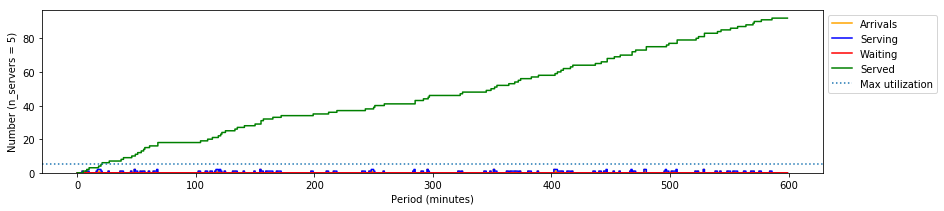

In [26]:
print ('===',processes_with_variability[0].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_check_in_final))
print ('Total served: {}'.format(served_check_in_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_check_in_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_check_in_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_check_in_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_check_in_final + mean_service_time_check_in_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_check_in)))

fig, ax1 = plt.subplots(figsize = (14, 3))

ax1.step(periods, check_in['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, check_in['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, check_in['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, check_in['Completed_cumu'], c = 'green', label = 'Served')

ax1.axhline(servers_check_in, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, max(check_in.iloc[:, :-1].max().max(), servers_check_in) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_check_in))

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [27]:
# Summary stats for refine_complaint
arrived_refine_complaint_final = refine_complaint['Arrivals'].sum()
served_refine_complaint_final = refine_complaint['Completed'].sum()
mean_service_time_refine_complaint_final = np.mean(service_times_completed_list_refine_complaint)
mean_patients_waiting_refine_complaint_final = refine_complaint['Waiting'].mean()
mean_waiting_time_refine_complaint_final = np.sum(waiting_time_list_refine_complaint)\
                                            / served_refine_complaint_final

=== REFINE_COMPLAINT ===

Total arrived: 92.0
Total served: 89.0
Mean service time: 23.87
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 23.87
Mean waiting time for those who waited: nan


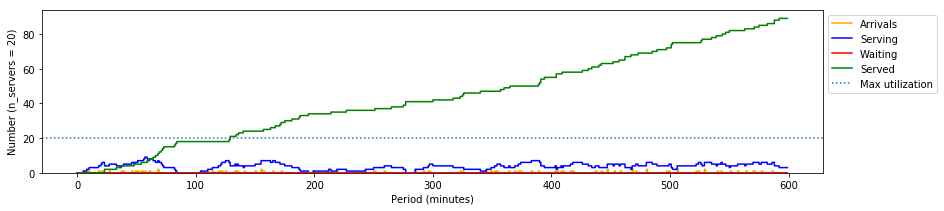

In [28]:
print ('===',processes_with_variability[1].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_refine_complaint_final))
print ('Total served: {}'.format(served_refine_complaint_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_refine_complaint_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_refine_complaint_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_refine_complaint_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_refine_complaint_final\
                                            + mean_service_time_refine_complaint_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_refine_complaint)))

fig, ax1 = plt.subplots(figsize = (14, 3))

ax1.step(periods, refine_complaint['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, refine_complaint['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, refine_complaint['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, refine_complaint['Completed_cumu'], c = 'green', label = 'Served')

ax1.axhline(servers_refine_complaint, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, max(refine_complaint.iloc[:, :-1].max().max(), servers_refine_complaint) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_refine_complaint))

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [29]:
# Summary stats for exam
arrived_exam_final = exam['Arrivals'].sum()
served_exam_final = exam['Completed'].sum()
mean_service_time_exam_final = np.mean(service_times_completed_list_exam)
mean_patients_waiting_exam_final = exam['Waiting'].mean()
mean_waiting_time_exam_final = np.sum(waiting_time_list_exam) / served_exam_final

=== EXAM ===

Total arrived: 89.0
Total served: 85.0
Mean service time: 25.13
Mean n_patients waiting: 0.00
Mean waiting time: 0.01
Mean time in system: 25.14
Mean waiting time for those who waited: 1.00


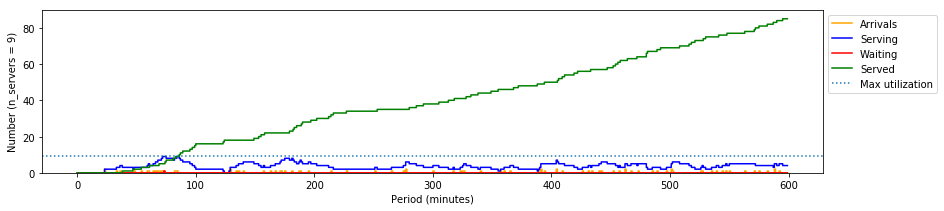

In [30]:
print ('===',processes_with_variability[2].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_exam_final))
print ('Total served: {}'.format(served_exam_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_exam_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_exam_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_exam_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_exam_final + mean_service_time_exam_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_exam)))

fig, ax1 = plt.subplots(figsize = (14, 3))

ax1.step(periods, exam['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, exam['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, exam['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, exam['Completed_cumu'], c = 'green', label = 'Served')

ax1.axhline(servers_exam, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, max(exam.iloc[:, :-1].max().max(), servers_exam) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_exam))

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [31]:
# Summary stats for checkout
arrived_checkout_final = checkout['Arrivals'].sum()
served_checkout_final = checkout['Completed'].sum()
mean_service_time_checkout_final = np.mean(service_times_completed_list_checkout)
mean_patients_waiting_checkout_final = checkout['Waiting'].mean()
mean_waiting_time_checkout_final = np.sum(waiting_time_list_checkout) / served_checkout_final

=== CHECKOUT ===

Total arrived: 85.0
Total served: 85.0
Mean service time: 5.26
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 5.26
Mean waiting time for those who waited: nan


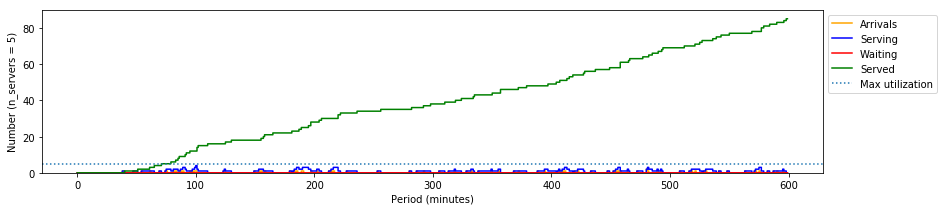

In [32]:
print ('===',processes_with_variability[3].upper(),'===\n')
print ('Total arrived: {}'.format(arrived_checkout_final))
print ('Total served: {}'.format(served_checkout_final))
print ('Mean service time: {:.2f}'.format(mean_service_time_checkout_final))
print ('Mean n_patients waiting: {:.2f}'.format(mean_patients_waiting_checkout_final))
print ('Mean waiting time: {:.2f}'.format(mean_waiting_time_checkout_final))
print ('Mean time in system: {:.2f}'.format(mean_waiting_time_checkout_final + mean_service_time_checkout_final))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list_checkout)))

fig, ax1 = plt.subplots(figsize = (14, 3))

ax1.step(periods, checkout['Arrivals'], c = 'orange', label = 'Arrivals')
ax1.step(periods, checkout['Serving'], c = 'blue', label = 'Serving')
ax1.step(periods, checkout['Waiting'], c = 'red', label = 'Waiting')
ax1.step(periods, checkout['Completed_cumu'], c = 'green', label = 'Served')

ax1.axhline(servers_checkout, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, max(checkout.iloc[:, :-1].max().max(), servers_checkout) + 5)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(servers_checkout))

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [33]:
print ('Mean time check_in: {:.2f}'.format(mean_waiting_time_check_in_final + mean_service_time_check_in_final))
print ('Mean time waiting room -> refine complaint: {:.2f}'\
       .format(mean_waiting_time_refine_complaint_final + mean_service_time_refine_complaint_final))
print ('Mean time exam: {:.2f}'.format(mean_waiting_time_exam_final + mean_service_time_exam_final))
print ('Mean time checkout: {:.2f}'.format(mean_waiting_time_checkout_final + mean_service_time_checkout_final))
total_time_in_system_final = mean_waiting_time_check_in_final + mean_service_time_check_in_final\
        + mean_waiting_time_refine_complaint_final + mean_service_time_refine_complaint_final\
        + mean_waiting_time_exam_final + mean_service_time_exam_final\
        + mean_waiting_time_checkout_final + mean_service_time_checkout_final
print ('Mean time TOTAL: {:.2f}'.format(total_time_in_system_final))

Mean time check_in: 2.02
Mean time waiting room -> refine complaint: 23.87
Mean time exam: 25.14
Mean time checkout: 5.26
Mean time TOTAL: 56.29


In [34]:
print ('Estimated time - preventative:', process_flow['Time_Mean'].sum()\
                            + base_case_types.loc[base_case_types['Type'] == 'Preventative', 'Time_Mean'].item())
print ('Estimated time - chronic:', process_flow['Time_Mean'].sum()\
                            + base_case_types.loc[base_case_types['Type'] == 'Chronic', 'Time_Mean'].item())
print ('Estimated time - acute:', process_flow['Time_Mean'].sum()\
                            + base_case_types.loc[base_case_types['Type'] == 'Acute', 'Time_Mean'].item())

Estimated time - preventative: 59.0
Estimated time - chronic: 59.0
Estimated time - acute: 44.0


In [35]:
# Clear variables to re-run
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
